In [5]:
# Here we try to implement the time series forecasting using the machine learning models.
# We will use the data from 'feeds.csv' file.
# It contains columns: 'Created_at', 'Entry_id', 'Field1', 'Latitude', 'Longitude', 'Elevation', 'Status'
# The 'Created_at' column contains the date and time of the data entry.
# The 'Entry_id' column contains the unique id for each entry.
# The 'Field1' column contains the Air Quality Index (AQI) value.

# The models we will use are: Arima

# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import the libraries for arima model
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

Reading and cleaning dataset

In [6]:
# Read the data from the csv file
df = pd.read_csv('feeds.csv')
df

,created_at,entry_id,field1,latitude,longitude,elevation,status
0,2023-12-08T23:34:22+05:30,1,33.69141,NaN,NaN,NaN,NaN
1,2023-12-08T23:34:45+05:30,2,33.59375,NaN,NaN,NaN,NaN
2,2023-12-08T23:35:07+05:30,3,33.69141,NaN,NaN,NaN,NaN
3,2023-12-08T23:35:33+05:30,4,33.69141,NaN,NaN,NaN,NaN
4,2023-12-08T23:35:56+05:30,5,33.20313,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3390,2023-12-09T23:20:44+05:30,3391,19.62891,NaN,NaN,NaN,NaN
3391,2023-12-09T23:21:06+05:30,3392,19.53125,NaN,NaN,NaN,NaN
3392,2023-12-09T23:21:29+05:30,3393,20.60547,NaN,NaN,NaN,NaN
3393,2023-12-09T23:21:53+05:30,3394,20.80078,NaN,NaN,NaN,NaN


In [7]:
# Delete the data before '2023-12-09T00:50:27+05:30'
df = df[df['created_at'] > '2023-12-09T00:50:27+05:30']
df


,created_at,entry_id,field1,latitude,longitude,elevation,status
181,2023-12-09T00:50:45+05:30,182,23.82813,NaN,NaN,NaN,NaN
182,2023-12-09T00:51:10+05:30,183,23.82813,NaN,NaN,NaN,NaN
183,2023-12-09T00:52:08+05:30,184,23.92578,NaN,NaN,NaN,NaN
184,2023-12-09T00:52:39+05:30,185,23.82813,NaN,NaN,NaN,NaN
185,2023-12-09T00:53:01+05:30,186,23.82813,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3390,2023-12-09T23:20:44+05:30,3391,19.62891,NaN,NaN,NaN,NaN
3391,2023-12-09T23:21:06+05:30,3392,19.53125,NaN,NaN,NaN,NaN
3392,2023-12-09T23:21:29+05:30,3393,20.60547,NaN,NaN,NaN,NaN
3393,2023-12-09T23:21:53+05:30,3394,20.80078,NaN,NaN,NaN,NaN


Before removing outliers:  (3214, 7)
After removing outliers:  (3065, 7)


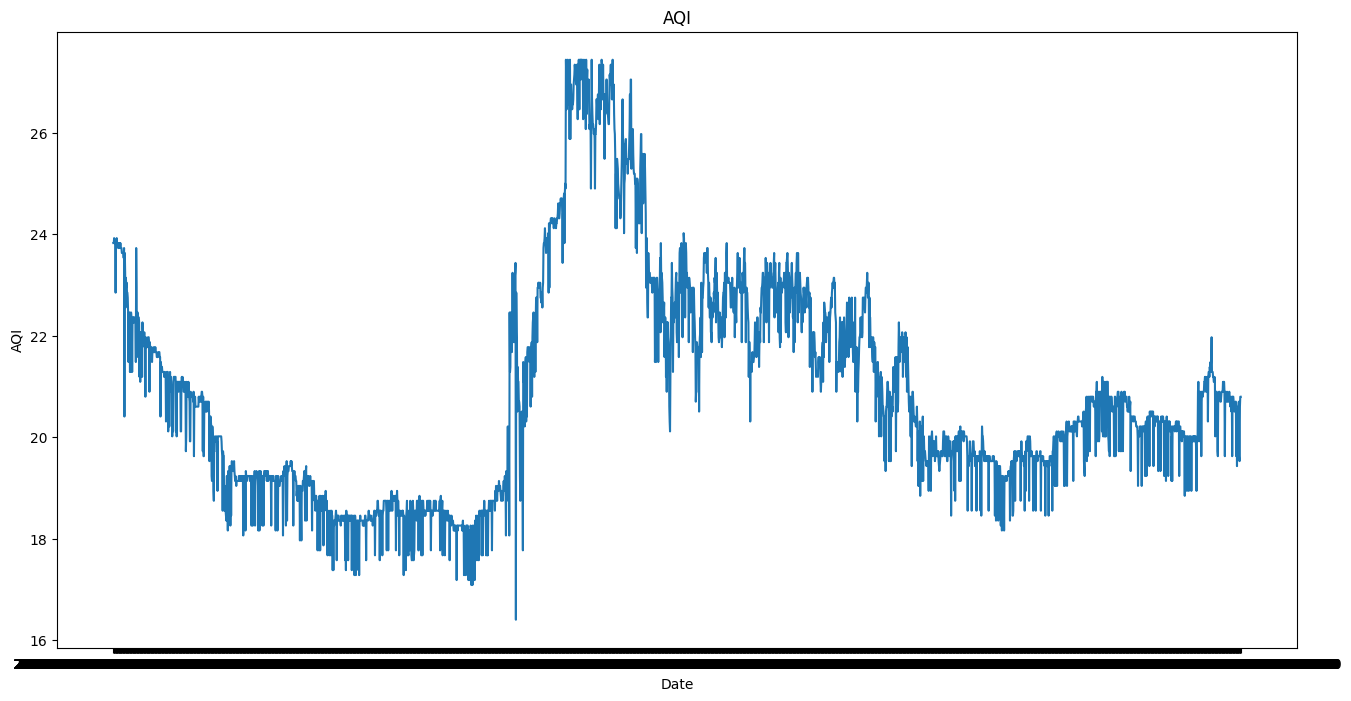

In [8]:

# Remove the outliers
print("Before removing outliers: ", df.shape)
Q1 = df['field1'].quantile(0.25)
Q3 = df['field1'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['field1'] < (Q1 - 1.5 * IQR)) |(df['field1'] > (Q3 + 1.5 * IQR)))]
print("After removing outliers: ", df.shape)

# Plot the data 
plt.figure(figsize=(16,8))
plt.title('AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(df['created_at'], df['field1'])
plt.show()

In [9]:
# Delete the columns which are not required
df = df[['created_at', 'field1']]
# Convert the 'created_at' column to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
# Set the time column as the index
df = df.set_index('created_at')
df

,field1
created_at,
2023-12-09 00:50:45+05:30,23.82813
2023-12-09 00:51:10+05:30,23.82813
2023-12-09 00:52:08+05:30,23.92578
2023-12-09 00:52:39+05:30,23.82813
2023-12-09 00:53:01+05:30,23.82813
...,...
2023-12-09 23:20:44+05:30,19.62891
2023-12-09 23:21:06+05:30,19.53125
2023-12-09 23:21:29+05:30,20.60547


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2013 entries, 2023-12-09 00:50:45+05:30 to 2023-12-09 14:58:49+05:30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   field1  2013 non-null   float64
dtypes: float64(1)
memory usage: 31.5 KB


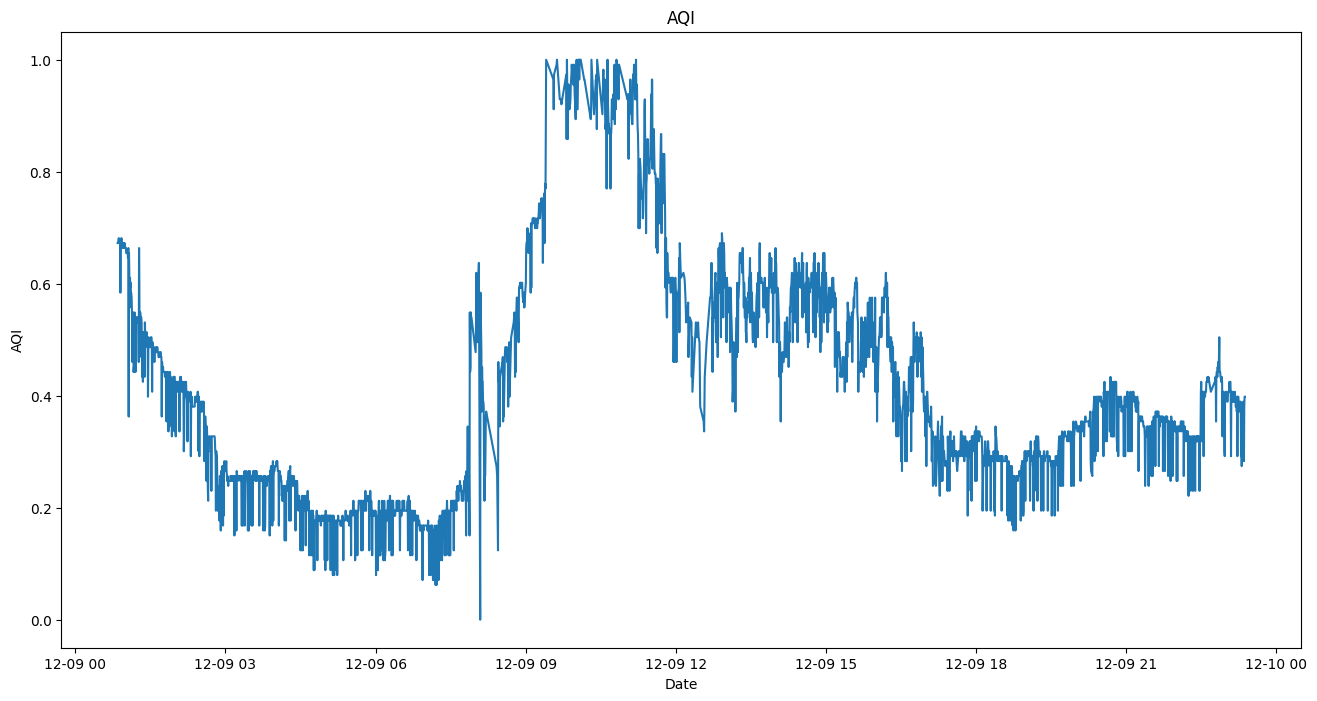

In [10]:
# Normalize the voltage column to the range [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['field1'] = scaler.fit_transform(df[['field1']])
# Plot the data 
plt.figure(figsize=(16,8))
plt.title('AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(df['field1'])
plt.show()

Data Preprocessing

In [11]:
# Define the sequence length and the output size
seq_len = 50
output_size = 1

In [15]:
ratio = 0.8 # 80% of the data will be used for training
train_size = int(len(df) * ratio)
test_size = len(df) - train_size
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train and test size: ", len(train), len(test))

Train and test size:  2452 613


Model Training

In [13]:
# Use the TimeSeriesGenerator class to prepare the data
from keras.preprocessing.sequence import TimeseriesGenerator
train_gen = TimeseriesGenerator(train['field1'].values, train['field1'].values, length=seq_len, batch_size=1)
test_gen = TimeseriesGenerator(test['field1'].values, test['field1'].values, length=seq_len, batch_size=1)

In [20]:
# Define the model
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Create a sequential model with past 'seq_len' inputs and 'output_size' as output as prediction 
model = Sequential()
# Add only one LSTM layer
model.add(LSTM(32, input_shape=(seq_len, 1)))
# Add the output layer
model.add(Dense(output_size))
# Print the model summary with input and output shapes of each layer
# Compile the model
# Use the mean squared error as the loss function
model.compile(loss='mse', optimizer='adam')
# Use the root mean squared error as the metric
from keras.metrics import RootMeanSquaredError
model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])
model.summary()
print("Model compiled successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model compiled successfully!


In [21]:
# Fit the model
# Train the model for 20 epochs
model.fit(train_gen, epochs=5, validation_data=test_gen, verbose=1)


Epoch 1/5
2402/2402 [==============================] - 23s 9ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 2/5
2402/2402 [==============================] - 21s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 3/5
2402/2402 [==============================] - 21s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 4/5
2402/2402 [==============================] - 22s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 5/5
2402/2402 [==============================] - 22s 9ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365


 Model Evaluation and Visualization

In [22]:
# Evaluate the model
# Calculate the root mean squared error on the test set
test_rmse = model.evaluate(test_gen)[1]
print(f'The root mean squared error on the test set is {test_rmse:.4f}')

563/563 [==============================] - 1s 2ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365
The root mean squared error on the test set is 0.0365


563/563 [==============================] - 1s 2ms/step


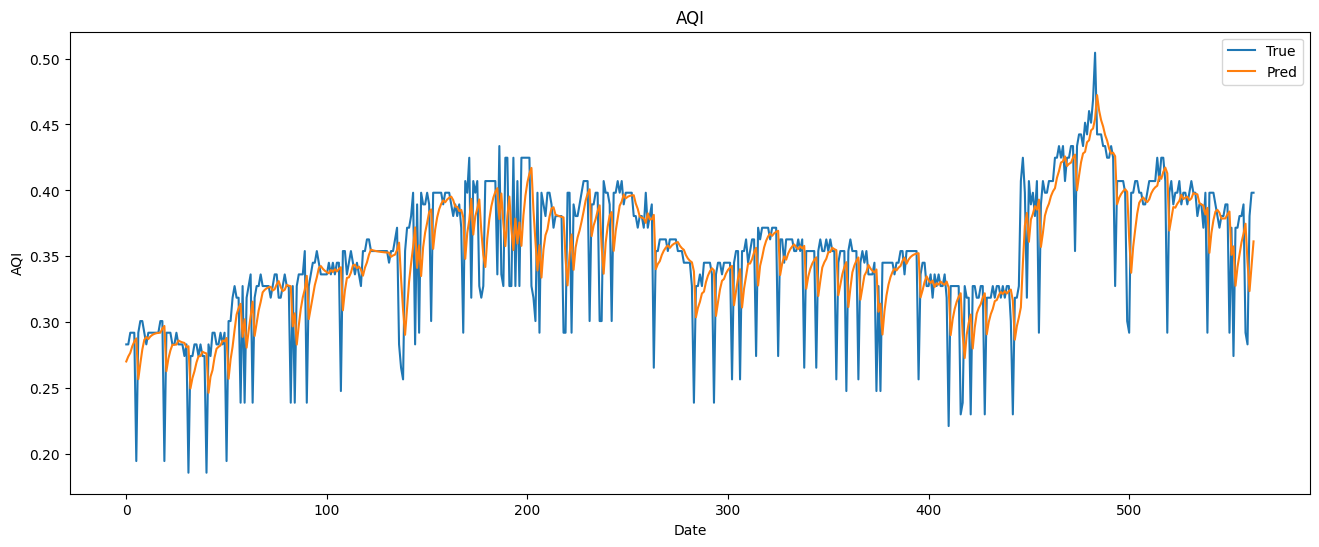

In [23]:
# Plot the predictions against the actual values for the test set using plotly for visualization
# Get the predictions 
predictions = model.predict(test_gen)
# Get the true values
true_values = test['field1'].values[seq_len:seq_len+len(predictions)]
# Create a dataframe with the true values and predictions
pred_df = pd.DataFrame({'True': true_values, 'Pred': predictions.reshape(-1)[:len(true_values)]})

# Plot the predictions against the actual values for the test set for visualization
plt.figure(figsize=(16,6))
plt.title('AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.plot(pred_df['True'], label='True')
plt.plot(pred_df['Pred'], label='Pred')
plt.legend()
plt.show()


In [65]:
# Calculate the MAE, RMSE, MAPE
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_values, predictions)
rmse = mean_squared_error(true_values, predictions, squared=False)
mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100

print(f'The MAE is {mae:.4f}.')
print(f'The RMSE is {rmse:.4f}.')
print(f'The MAPE is {mape:.4f}%.')

The MAE is 0.0276.
The RMSE is 0.0369.
The MAPE is 11.9958%.


Exporting Model 

In [63]:
# Save the model as a h5 file
model.save('lstm_model.h5')
print("Model saved as a h5 file successfully!")
# Save the scaler as a pickle file
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Model and scaler saved successfully!")

# Save the model
model.save('lstm_model.keras')
print("Model saved as a keras file successfully!")

# Convert the model to TensorFlow Lite
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('lstm_model.h5')

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False  # Disable lowering tensor list ops
tflite_model = converter.convert()

# Save the model
with open('lstm_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted successfully and saved as a tflite file!")

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Model saved as a h5 file successfully!
Model and scaler saved successfully!
Model saved as a keras file successfully!
INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp2c7qkwgq\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp2c7qkwgq\assets


Model converted successfully and saved as a tflite file!


In [2]:
# Load the model 
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path='lstm_model-1.tflite')

# Get the input and output details of the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Display the dimensions of the input and output
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

print(f'The input shape is {input_shape}')
print(f'The output shape is {output_shape}')


The input shape is [ 1 50  1]
The output shape is [1 1]


INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 2 nodes delegated out of 10 nodes with 2 partitions.



In [44]:
# Make a program that randomly generates the testdata and returns the prediction
# Make this cell such that it can be run multiple times to get different results without having to run the previous cells again

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Load the model
interpreter = tf.lite.Interpreter(model_path='lstm_model-1.tflite')
interpreter.allocate_tensors()

# Get the input and output details of the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# define 'seq_len' and 'output_size' from the model
seq_len = input_details[0]['shape'][1]
output_size = output_details[0]['shape'][1]

# Define the function to generate the test data
def generate_testdata():
    # Generate the test data in the required shape
    test_data = np.random.rand(seq_len).reshape(1, seq_len, 1).astype(np.float32)  # Convert to FLOAT32
    # Get the true values
    true_values = test_data.reshape(-1)[seq_len-output_size:]
    # Set the input and output tensors to the test data and get the prediction
    interpreter.set_tensor(input_details[0]['index'], test_data)
    interpreter.invoke()
    pred_values = interpreter.get_tensor(output_details[0]['index'])
    return test_data, true_values.reshape(output_details[0]['shape']), pred_values

# Print the test data, true values and prediction values
test_data, true_values, pred_values = generate_testdata()
print("Test data: ")
print(test_data)
print("True values: ")
print(true_values)
print("Prediction values: ")
print(pred_values)
    


Test data: 
[[[0.773074  ]
  [0.19236575]
  [0.9380096 ]
  [0.8044515 ]
  [0.36608627]
  [0.23452882]
  [0.7188826 ]
  [0.4364248 ]
  [0.9366923 ]
  [0.4831367 ]
  [0.3126962 ]
  [0.9747026 ]
  [0.27282694]
  [0.18240224]
  [0.00489609]
  [0.1368823 ]
  [0.03513393]
  [0.8967004 ]
  [0.01364386]
  [0.2626355 ]
  [0.45512456]
  [0.57491934]
  [0.07577874]
  [0.40693694]
  [0.36035377]
  [0.17713934]
  [0.22114836]
  [0.08022314]
  [0.07290836]
  [0.0612666 ]
  [0.41425893]
  [0.6561103 ]
  [0.5553418 ]
  [0.865937  ]
  [0.9437474 ]
  [0.6408964 ]
  [0.41770756]
  [0.4700445 ]
  [0.90261585]
  [0.370165  ]
  [0.24125853]
  [0.31666702]
  [0.86707854]
  [0.4470701 ]
  [0.06812177]
  [0.19535089]
  [0.66156375]
  [0.10699667]
  [0.86377966]
  [0.32769677]]]
True values: 
[[0.32769677]]
Prediction values: 
[[0.45141557]]
